In [1]:
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, zscore, pearsonr, wilcoxon
import pybedtools as pbt
from scipy.integrate import simps
from IPython.display import clear_output
import pandas as pd
from ipyparallel import Client

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json


OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

In [23]:
def calc_stats(chrom):
    import numpy as np
    
    def approx_motifs(a):
        ctr = 0
        cctr = {}
        for i in a:
            if i not in cctr:
                cctr[i] = 0
            cctr[i]+=1
            if cctr[i] == 12:
                cctr[i] = 0
                ctr+=1
        return ctr
    
    num_g = {'positive': [], 'negative': []}
    motifs = {'positive': [], 'negative': []}
    cut_offs = [0, 1, 50, 185, 700, 900, 999]
    indir = '/home/parashar/scratch/quadcomb/data/snipr'
    for strand in ['positive', 'negative']:
        fn_in = '%s/%s_%s_scores.npy' % (indir, chrom, strand)
        a = np.load(fn_in)
        nz = a[a > 0]
        for cf in cut_offs:
            b = nz[nz > cf]
            num_g[strand].append(len(b))
            motifs[strand].append(approx_motifs(b))
    return num_g, motifs

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
res = DVIEW.map_sync(calc_stats, chroms)
len(res)

24

In [24]:
cut_offs = [0, 1, 50, 185, 700, 900, 999]
for i in range(len(cut_offs)):
    num_gs = 0
    num_motifs = 0
    for j in res:
        num_gs += j[0]['positive'][i] + j[0]['negative'][i]
        num_motifs += j[1]['positive'][i] + j[1]['negative'][i]
    print (cut_offs[i], num_gs, num_motifs)

0 463979805 38649455
1 463510714 38610388
50 196646360 16372786
185 95931490 7982850
700 6823927 567642
900 1098821 91480
999 221083 18402


In [4]:
ctrs = {}
spans = {}
gs = {}
for chrom in chroms:
    ctr = 0
    g4_bed = '/home/parashar/scratch/quadruplexes/hg19/g3_25_3_%s_nov.bed' % chrom
    ctr = 0
    span = 0
    g = 0
    with open(g4_bed) as h:
        for l in h:
            c = l.rstrip('\n').split('\t')
            s = int(c[2]) - int(c[1])
            span+=s
            ctr+=1
            g4 = c[5].upper()
            if c[4][0] == "G":
                g+= g4.count('G')
            else:
                g+= g4.count('C')
    gs[chrom] = g
    ctrs[chrom] = ctr
    spans[chrom] = span
    print (chrom, ctr, span, g)

chr1 1321161 85291319 31251140
chr2 1226167 78669321 28509809
chr3 951888 60788075 21859576
chr4 799379 50902253 18179073
chr5 854794 54591512 19621133
chr6 812411 51889073 18703767
chr7 833742 53707659 19586063
chr8 726152 46553563 16836469
chr9 675822 43641806 15955078
chr10 753906 48636568 17733231
chr11 756784 48798204 17883260
chr12 705205 45302129 16481593
chr13 420186 26808138 9609204
chr14 480628 30959662 11276882
chr15 493240 31838111 11653472
chr16 567869 37049266 13774527
chr17 591335 38765191 14532128
chr18 365959 23406491 8449468
chr19 492849 32781196 12505648
chr20 412287 26802015 9924104
chr21 191268 12414207 4548579
chr22 306113 20261111 7668583
chrX 719905 45908775 16415236
chrY 127738 8239484 2921299


In [197]:
sum(list(ctrs.values()))

537072052

In [3]:
from SNIPRQ import QuadPaths, StemGroups
import matplotlib.pyplot as plt
from matplotlib import gridspec
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx

In [1]:
chrom_fn = '/home/parashar/scratch/hg19_resource/chromosomes/chr8.fa'
chrom_seq = ''.join([x.rstrip('\n').upper() for x in open(chrom_fn).readlines()[1:]])
len(chrom_seq)

146364022

In [90]:
def plot_graph(G, s, e):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    fig.set_facecolor('#eeeeee')
    
    node_pos = graphviz_layout(G, prog='dot')
    c_map = {0: 'crimson', 5: 'lightskyblue', 4: 'dodgerblue',
             3: 'royalblue', 2: 'blue', 1: 'navy'
        
    }
    node_colors = [c_map[x.count('-')] for x in G.nodes()]
    #node_size = [200 + v * 50 for v in nx.degree(G).values()]
    nx.draw_networkx(G, node_pos, node_size=50, node_color=node_colors,
                     with_labels=False, ax=ax, width=0.15, cmap='Blues')
    ax.set_axis_bgcolor('#eeeeee')
    ax.set_xticks([])
    ax.set_yticks([])
    for i in ax.spines.values():
        i.set_edgecolor('#eeeeee')

    fig.tight_layout()
    plt.savefig('../images/example_graphs_%d_%d.svg' % (s, e),
                     transparent=True, edgecolor='none')
    plt.show()
    return node_pos

86308582 86308592
86308621 86308852
38 118 231


/home/parashar/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


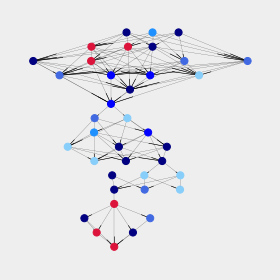

86308921 86309127
33 103 206


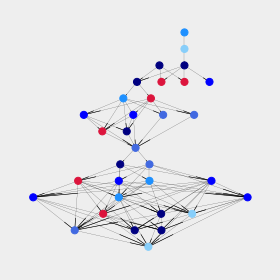

86309177 86309208
86309245 86309302
16 72 57


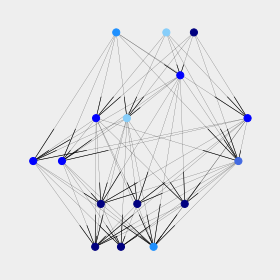

86309344 86309423
8 7 79


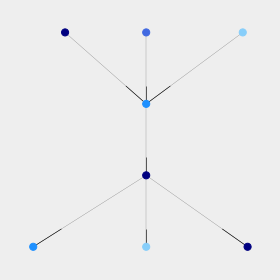

86309458 86309544
28 177 86


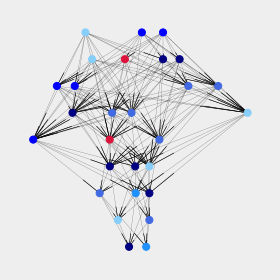

In [94]:
seq_start = 86308582
seq = chrom_seq[seq_start:86309800]
sg_obj = StemGroups(sequence=seq, max_loop_len=25, max_bulge_len=5, base='G')
for sg in sg_obj.generate_stems():
    start = sg[0][0]
    stop = sg[-1][-1]
    qp_obj = QuadPaths(stems=sg, max_loop_len=25)
    print (start+seq_start,stop+seq_start)
    if len(qp_obj.G.nodes()) > 0:
        print (len(qp_obj.G.nodes()), len(qp_obj.G.edges()), stop-start)
        node_pos = plot_graph(qp_obj.G, start+seq_start, stop+seq_start)

In [93]:
86308621-86308852, 86308921-86309127, 86309245-86309302

(-231, -206, -57)

In [95]:
86308852-86308921, 86309127-86309245

(-69, -118)

In [104]:
import numpy as np
import matplotlib.pyplot as plt

In [139]:
def scorer(qp):
    loop_lens = qp[:, 0][1:] - qp[: , 2][:-1] - 1
    bulge_lens = [x[2] - x[0] - 2 for x in qp]
    a = 1/look_up_table[(bulge_lens[0], loop_lens[0], bulge_lens[1])]
    b = 1/look_up_table[(bulge_lens[1], loop_lens[1], bulge_lens[2])]
    c = 1/look_up_table[(bulge_lens[2], loop_lens[2], bulge_lens[3])]
    return int(3/(a+b+c))

def load_table():
    look_up_table = {}
    with open('../data/table_stem_loop_stem_frequency.csv') as h:
        next(h)
        for l in h:
            c = l.rstrip('\n').split(',')
            look_up_table[(int(c[0]), int(c[1]), int(c[2]))] = int(c[5])
            look_up_table[(int(c[2]), int(c[1]), int(c[0]))] = int(c[5])
    return look_up_table

look_up_table = load_table()

0 15 [4, 6, 1, 0, 14]


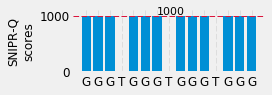

0 16 [4, 6, 1, 0, 15]


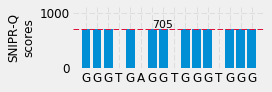

0 18 [4, 6, 1, 0, 17]


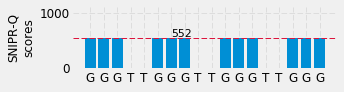

0 20 [4, 6, 1, 0, 19]


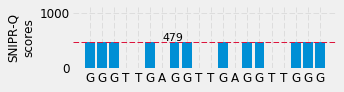

0 19 [4, 6, 1, 0, 18]


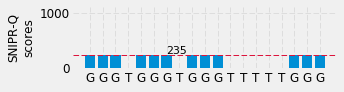

0 27 [4, 6, 1, 0, 26]


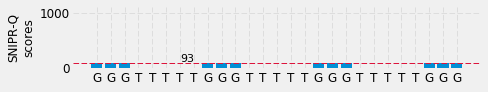

0 26 [4, 6, 1, 0, 25]


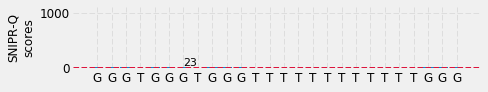

0 19 [4, 6, 1, 0, 18]


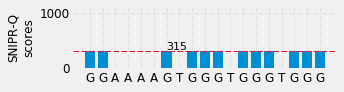

0 31 [4, 6, 1, 0, 30]


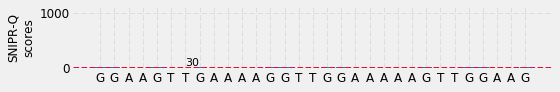

In [176]:
seqs = [
    'GGGTGGGTGGGTGGG',
    'GGGTGAGGTGGGTGGG',   
    'GGGTTGGGTTGGGTTGGG',
    'GGGTTGAGGTTGAGGTTGGG',
    'GGGTGGGTGGGTTTTTGGG',
    'GGGTTTTTGGGTTTTTGGGTTTTTGGG',
    'GGGTGGGTGGGTTTTTTTTTTTTGGG',
    'GGAAAAGTGGGTGGGTGGG',
    'GGAAGTTGAAAAGGTTGGAAAAAGTTGGAAG',
]

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

fig_num = 1
for seq in seqs:
    sg_obj = StemGroups(sequence=seq, max_loop_len=25, max_bulge_len=5, base='G')
    for sg in sg_obj.generate_stems():
        start = sg[0][0]
        stop = sg[-1][-1]
        max_scores = np.zeros(stop-start+1, dtype=int)
        qp_obj = QuadPaths(stems=sg, max_loop_len=25)
        for qp in qp_obj.QPS:
            score = scorer(qp)
            qpf = qp.flatten()-start
            max_scores[qpf[max_scores[qpf] < score]] = score
        if qp_obj.info != []:
            print (start, stop+1, qp_obj.info)
            fig, ax = plt.subplots(1, 1, figsize=(len(seq)//3.5, 1.5))
            ax.bar(range(stop-start+1), max_scores)
            ax.axhline(max(max_scores), lw=1, ls='--', c='crimson')
            ax.set_ylim((0, 1100))
            ax.set_xticks(range(len(max_scores)))
            ax.set_xticklabels(list(seq))
            ax.set_ylabel('SNIPR-Q\nscores', fontsize=12)
            ax.text(6, max(max_scores)+20, max(max_scores), fontsize=11)
            clean_axis(ax)
            plt.tight_layout()
            plt.savefig('../images/example_sequence_sniprq_%d.svg' % fig_num,
                        transparent=True, edgecolor='none')
            plt.show()
            fig_num += 1